In [1]:
import pandas as pd 
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import pairwise_kernels
from random import sample
import random

from conditionalconformal import CondConf
from conditionalconformal.condconf import setup_cvx_problem_calib
from crossval import runCV

%load_ext autoreload
%autoreload 2

In [2]:
attrib = pd.read_csv('data/CandCData/attributes.csv', delim_whitespace = True)
data = pd.read_csv('data/CandCData/communities.data', names = attrib['attributes'])
features = ['population','racepctblack','racePctWhite','racePctAsian',
            'racePctHisp','agePct12t21','agePct65up','medIncome','PctUnemployed','ViolentCrimesPerPop']
dataSub = data[features]


In [ ]:
### Compute empirical coverage under a kernel re-weighting
def computeCovAtKernelShift(XTest,coverages,XShift,gamma):
    f = pairwise_kernels(
                X=pd.Series.to_numpy(XShift).reshape(1, -1),
                Y=XTest,
                metric="rbf",
                gamma=gamma
            )[0,:]
    return np.average(coverages, weights=f)

### Run a simulation with one train-calibration-test split
def oneExpRun(X,Y,nTest,nCalib,alpha,gamma,protectedFeatures,featuresToPlot,cutoffs,
                                    minRad,maxRad,numRad,k,shiftLocs,radius=None, eps = 0.00001):
    ### Split the data into training, calibration, and testing sets
    fullTrainingSet = sample(set(range(0,len(Y))) - set(shiftLocs),len(Y) - nTest) ### Always but the rows in shiftLocs into the test set
    testPoints = list(set(range(0,len(Y))) - set(fullTrainingSet))
    calibPoints = fullTrainingSet[0:nCalib]
    trainPoints = fullTrainingSet[nCalib:]
    
    XTest = pd.DataFrame.to_numpy(X.iloc[testPoints,:])
    YTest = pd.Series.to_numpy(Y.iloc[testPoints])
    XCalib = pd.DataFrame.to_numpy(X.iloc[calibPoints,:])
    YCalib = pd.Series.to_numpy(Y.iloc[calibPoints])
    XTrain = pd.DataFrame.to_numpy(X.iloc[trainPoints,:])
    YTrain = pd.Series.to_numpy(Y.iloc[trainPoints])
    
    ### Compute conformity scores
    reg = LinearRegression().fit(XTrain,YTrain)
    scoreFn = lambda x, y : y - reg.predict(x)
    
    scoresCalib = np.abs(reg.predict(XCalib) - YCalib)
    scoresTest =  np.abs(reg.predict(XTest) - YTest)
    
    ### Run split conformal
    qSplitConf = np.quantile(scoresCalib, [(1-alpha) * (1 + 1/nCalib)])
    splitCovs = scoresTest <= qSplitConf
    splitMargCov = np.mean(splitCovs)
        
    ### Compute phi()
    phiFn = lambda x : x[:,protectedFeatures]
    phiCalib = phiFn(XCalib)
    phiTest = phiFn(XTest)

    ### Run cross-validation to get regularization parameter
    if radius is None:
        allLosses, radii = runCV(XCalib,scoresCalib,'rbf',gamma,alpha,k,
                                 minRad,maxRad, numRad, phiCalib)
        selectedRadius = radii[np.argmin(allLosses)]
    else:
        selectedRadius = radius
    
    ### Run our conditional calibration method on the test set
    condCovProgram = CondConf(scoreFn, phiFn, {'kernel': 'rbf', 'gamma': gamma, 'lambda' : 1/selectedRadius})
    condCovProgram.setup_problem(XCalib,YCalib)
    condConfCovs = condCovProgram.verify_coverage(XTest,YTest,1-alpha)[:,0]
    
    protectedResultsDF = pd.DataFrame({'Coverage' : [splitMargCov,np.mean(condConfCovs)],
                             'type' : ['Split Conformal','Conditional Calibration'],'Shift Type' : ['Marginal','Marginal'],
                                        'Quantile' : ['All','All']})
    
    ### Compute empirical coverage at subgroups given by cutoffs
    for q in cutoffs.keys(): 
        for feature in protectedFeatures:
            featureName = X.columns[feature]
            if featureName != 'intercept':
                condConfCov = np.mean(condConfCovs[X.iloc[testPoints,:][featureName]>cutoffs[q][featureName]])
                splitCov = np.mean(splitCovs[X.iloc[testPoints,:][featureName]>cutoffs[q][featureName]])

                shiftType = featureName + '>' + str(cutoffs[q][featureName])
                protectedDF = pd.DataFrame({'Coverage' : [splitCov, condConfCov],
                                 'type' : ['Split Conformal','Conditional Calibration'],'Shift Type' : [shiftType,shiftType],
                                            'Quantile' : [q,q]})
            
                protectedResultsDF = pd.concat([protectedResultsDF,protectedDF])
    
    ### Compute empirical coverage over linear re-weightings
    for feature in protectedFeatures: 
        featureName = X.columns[feature]
        if featureName != 'intercept':
            condConfCov = np.mean(condConfCovs*X.iloc[testPoints,:][featureName])/np.mean(X.iloc[testPoints,:][featureName])
            splitCov = np.mean(splitCovs*X.iloc[testPoints,:][featureName])/np.mean(X.iloc[testPoints,:][featureName])

            shiftType = featureName
            protectedDF = pd.DataFrame({'Coverage' : [splitCov, condConfCov],
                                 'type' : ['Split Conformal','Conditional Calibration'],'Shift Type' : [shiftType,shiftType],
                                            'Quantile' : ['Linear','Linear']})
            
            protectedResultsDF = pd.concat([protectedResultsDF,protectedDF])
    
    ### Compute empirical localized coverage over kernel re-weightings
    shiftResultsDF = pd.DataFrame()
    for shift in shiftLocs:
        empiricalCov = computeCovAtKernelShift(XTest,condConfCovs,X.iloc[shift,:],gamma)
        estimatedCov = condCovProgram.estimate_coverage(1-alpha,np.array([1]),X.iloc[shift,:].values.reshape(1,-1))[0]
                                                        
        shiftDF = pd.DataFrame({'Coverage' : [empiricalCov, estimatedCov],
                             'type' : ['Empirical','Estimated'],'Shift Type' : [shift,shift]})   
        shiftResultsDF = pd.concat([shiftResultsDF,shiftDF])
        
    ### Measure number of interpolated points in the fit
    interpolationDF = pd.DataFrame()
    for shift in shiftLocs:
        shiftIndex = testPoints.index(shift)
        XInterpTrain = np.row_stack((XCalib,XTest[shiftIndex,:]))
        scoresInterpTrain = np.concatenate((scoresCalib,[scoresTest[shiftIndex]]))
        phiInterpTrain = np.row_stack(([phiCalib,phiTest[shiftIndex,:]]))
        
        K = pairwise_kernels(
            X=XInterpTrain,
            Y=XInterpTrain,
            metric="rbf",
            gamma=gamma
        )
        prob = setup_cvx_problem_calib(1-alpha,XInterpTrain,scoresInterpTrain, phiInterpTrain,
                                           {'kernel': 'rbf', 'gamma': gamma, 'lambda' : 1/selectedRadius})
        if "MOSEK" in cp.installed_solvers():
            prob.solve(solver="MOSEK")
        else:
            prob.solve()
        predictedValues= K @ prob.var_dict['weights'].value + phiInterpTrain@prob.constraints[2].dual_value

        interpolatedPoints = np.abs(scoresInterpTrain - predictedValues) <= eps ### Check for interpolation up to a small amount of numerical error
        interpolationTotal = sum(interpolatedPoints*K[-1,:])/sum(K[-1,:]) ### Compute amount of interpolation under the kernel re-weighting
        
        interpolationOneShiftDF = pd.DataFrame({'Shift Type' : [shift], 'Interpolation' : [interpolationTotal]})
        interpolationDF = pd.concat([interpolationDF,interpolationOneShiftDF])


        
    return protectedResultsDF, shiftResultsDF, interpolationDF

random.seed(1)
X = dataSub.drop(['ViolentCrimesPerPop'],axis=1)
X['intercept'] = np.ones(len(X))
X.columns = ['population', '%Black', '%White', '%Asian',
               '%Hispanic', 'agePct12t21', 'agePct65up', 'medIncome',
               'PctUnemployed', 'intercept']
Y = dataSub['ViolentCrimesPerPop']
nTest = 694
nTrain = 650
nCalib = 650
nTrials = 200
n = nTrain + nCalib + nTest
alpha = 0.1
gamma = 4
protectedFeatures = [1,2,3,4,9]
protectedFeatureNames = X.columns[protectedFeatures]
featuresToPlot = ['medIncome','agePct65up']
shiftLocs = [37,65] 
minRad = 0.0001
maxRad = 1
numRad = 40
k = 5

quantiles = [0.5,0.7,0.9]
cutoffs = {}
for q in quantiles:
    cutoffq = {}
    for col in protectedFeatureNames:
        cutoffq[col] = round(np.quantile(X[col],q),2)
    cutoffs[q] = cutoffq

protectedDF = pd.DataFrame()
shiftDF = pd.DataFrame()
interpolationDF = pd.DataFrame()
for i in tqdm(range(nTrials)):
    appendDFProtected, appendDFShift, appendDFInterp = oneExpRun(X.iloc[0:n,:],Y[0:n],nTest,nCalib,alpha,gamma,
                                                       protectedFeatures,featuresToPlot,cutoffs,minRad, maxRad,
                                                       numRad, k, shiftLocs)
    appendDFProtected['trial'] = i
    appendDFShift['trial'] = i
    protectedDF = pd.concat([protectedDF,appendDFProtected])
    shiftDF = pd.concat([shiftDF,appendDFShift])
    interpolationDF = pd.concat([interpolationDF,appendDFInterp])


  5%|█████████▌                                                                                                                                                                                    | 10/200 [1:33:25<63:16:51, 1199.01s/it]

In [11]:
### Compute average amount of interpolation at the shifts of interest
mean1 = np.mean(interpolationDF['Interpolation'][interpolationDF['Shift Type'] == shiftLocs[0]])
mean2 = np.mean(interpolationDF['Interpolation'][interpolationDF['Shift Type'] == shiftLocs[1]])
print(mean1)
print(mean2)
print((mean1 + mean2)/2)

0.0056247319410957595
0.0021293971713594877
0.0038770645562276234


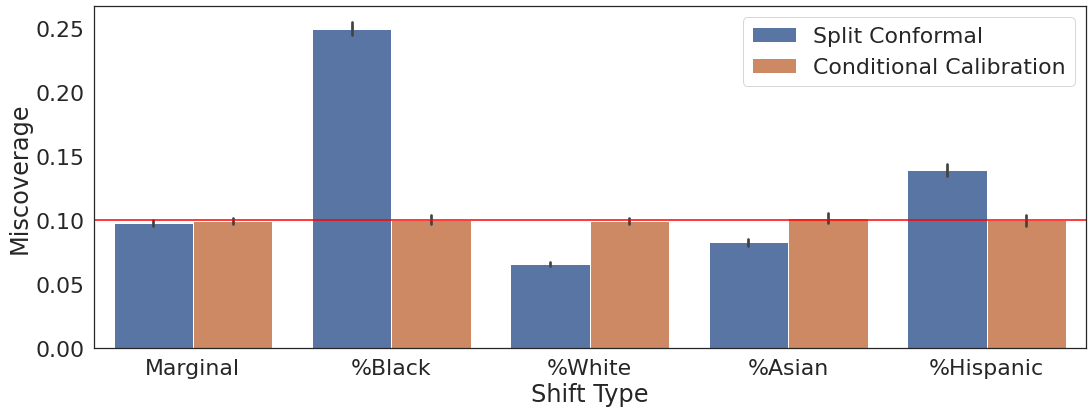

In [12]:
### Plot coverage under linear re-weightings
sns.set(rc={'figure.figsize':(15.7,6.27)})
sns.set(font_scale=2)
sns.set_style(style='white')

protectedDFSub = protectedDF[np.logical_or(protectedDF['Quantile'] == 'Linear', protectedDF['Quantile'] == 'All')].copy()

protectedDFSub['Miscoverage'] = 1-protectedDFSub['Coverage']

hueOrder = ['Split Conformal', 'Conditional Calibration']
fig = sns.barplot(protectedDFSub,x='Shift Type',y='Miscoverage',hue='type',hue_order=hueOrder,errorbar='ci')
fig.axhline(alpha, color='red')
plt.legend(title='')
plt.legend(loc='upper right')
plt.tight_layout()

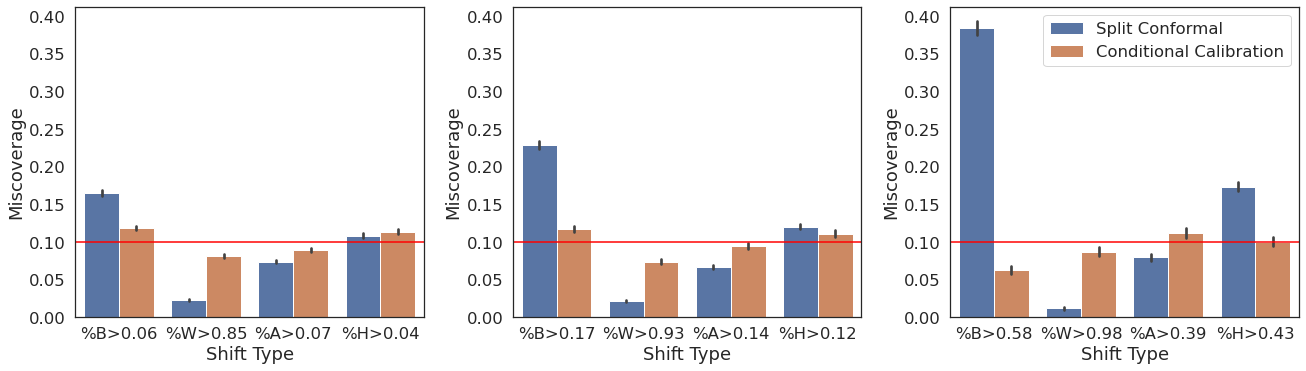

In [13]:
### Plot coverage at quantile cutoffs
sns.set(font_scale=1.5)
sns.set_style(style='white')
fig = plt.figure()
fig.set_size_inches(18.5, 5.5)

protectedDF['Miscoverage'] = 1-protectedDF['Coverage']

axes = []
figs = []
for i in range(len(quantiles)):
    if i >0:
        axes = axes + [fig.add_subplot(1, 3, i+1, sharey = axes[0])]
    else:
        axes = axes + [fig.add_subplot(1, 3, i+1)]
    protectedDFSub = protectedDF[protectedDF['Quantile'] == quantiles[i]]
    protectedDFSub = protectedDFSub.replace(to_replace='%Black>'+str(cutoffs[quantiles[i]]['%Black']),
                                                value='%B>'+str(cutoffs[quantiles[i]]['%Black']))
    protectedDFSub = protectedDFSub.replace(to_replace='%White>'+str(cutoffs[quantiles[i]]['%White']),
                                                value='%W>'+str(cutoffs[quantiles[i]]['%White']))
    protectedDFSub = protectedDFSub.replace(to_replace='%Hispanic>'+str(cutoffs[quantiles[i]]['%Hispanic']),
                                                value='%H>'+str(cutoffs[quantiles[i]]['%Hispanic']))
    protectedDFSub = protectedDFSub.replace(to_replace='%Asian>'+str(cutoffs[quantiles[i]]['%Asian']),
                                                value='%A>'+str(cutoffs[quantiles[i]]['%Asian']))

    hueOrder = ['Split Conformal', 'Conditional Calibration']
    figs = figs + [sns.barplot(protectedDFSub,x='Shift Type',y='Miscoverage',hue='type',
                               hue_order=hueOrder,errorbar='ci',ax=axes[i])]
    figs[i].axhline(alpha, color='red')
    if i == len(quantiles) - 1:
        plt.legend(title='')
        plt.legend(loc='upper right')
    else:
        plt.legend([],[], frameon=False)
plt.tight_layout()

In [79]:
### Run one train-calibration-test split and get estimated coverages for a guassian kernels centered at the points in the training 
### and calibration sets

### Split data
fullTrainingSet = sample(set(range(0,len(Y))) - set(shiftLocs),len(Y) - nTest)
testPoints = list(set(range(0,len(Y))) - set(fullTrainingSet))
calibPoints = fullTrainingSet[0:nCalib]
trainPoints = fullTrainingSet[nCalib:]
    
XTest = pd.DataFrame.to_numpy(X.iloc[testPoints,:])
YTest = pd.Series.to_numpy(Y.iloc[testPoints])
XCalib = pd.DataFrame.to_numpy(X.iloc[calibPoints,:])
YCalib = pd.Series.to_numpy(Y.iloc[calibPoints])
XTrain = pd.DataFrame.to_numpy(X.iloc[trainPoints,:])
YTrain = pd.Series.to_numpy(Y.iloc[trainPoints])

### Compute conformity score
reg = LinearRegression().fit(XTrain,YTrain)
scoresCalib = np.abs(reg.predict(XCalib) - YCalib)
scoresTest =  np.abs(reg.predict(XTest) - YTest)

### Compute phi
phiCalib = pd.DataFrame.to_numpy(X.iloc[calibPoints,:][protectedFeatureNames])
phiTest = pd.DataFrame.to_numpy(X.iloc[testPoints,:][protectedFeatureNames])

### Run cross-validation to get regularization hyperparameter
allLosses, radii = runCV(XCalib,scoresCalib,'rbf',gamma,alpha,k,
                                 minRad,maxRad, numRad, phiCalib)
selectedRadius = radii[np.argmin(allLosses)]

### Run our conditional calibration method and compute estimated coverages
prob = setup_cvx_problem_calib(1-alpha,XCalib,scoresCalib, phiCalib,
                                           {'kernel': 'rbf', 'gamma': gamma, 'lambda' : 1/selectedRadius})
if "MOSEK" in cp.installed_solvers():
    prob.solve(solver="MOSEK")
else:
    prob.solve()
kernelWeights = prob.var_dict['weights'].value

K = pairwise_kernels(
    X = np.vstack((XTrain,XCalib)),
    Y = XCalib,
    metric='rbf',
    gamma=gamma
)
covGaps = 1-alpha-(1/selectedRadius) * K @ kernelWeights / (K @ np.ones(len(calibPoints)) / len(calibPoints))


In [80]:
### Compute effective sample size at the chosen kernel shifts 
KShifts = pairwise_kernels(
    X = X.iloc[shiftLocs,:],
    Y = XTest,
    metric='rbf',
    gamma=gamma
)
ESS1 = sum(KShifts[0,:])**2/sum(KShifts[0,:]**2)
ESS2 = sum(KShifts[1,:])**2/sum(KShifts[1,:]**2)
print(ESS1)
print(ESS2)
print((ESS1 + ESS2)/2)

293.96411154992705
256.73751291710727
275.35081223351716


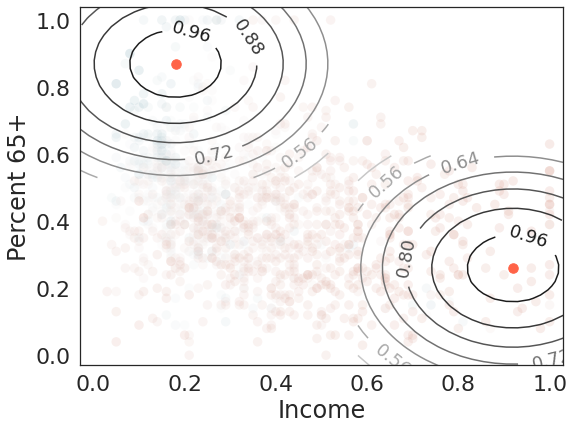

In [84]:
### Make a scatterplot of the estimated coverages
scatterplotDF = pd.DataFrame({'Income' : X['medIncome'][trainPoints + calibPoints],
                               'Percent 65+': X['agePct65up'][trainPoints + calibPoints],
                                                              'Estimated Coverage' : covGaps})

shiftDF['Miscoverage'] = 1-shiftDF['Coverage']

Xnp = pd.DataFrame.to_numpy(X)

shiftLocs.sort()
count = 1
for shift in shiftLocs:
    shiftDF.loc[shiftDF['Shift Type'] == shift, 'Shift Type'] = count
    count = count + 1
    
pointSize = 90
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()
fig.set_size_inches(8.5, 6.5)

f = sns.scatterplot(scatterplotDF,x='Income',y='Percent 65+',hue='Estimated Coverage',s=pointSize,alpha=0.15,
                edgecolor='none', palette = sns.diverging_palette(220, 20, as_cmap=True))
plt.scatter(x=X['medIncome'][shiftLocs[0]], y=X['agePct65up'][shiftLocs[0]], color='tomato',s=pointSize)
plt.scatter(x=X['medIncome'][shiftLocs[1]], y=X['agePct65up'][shiftLocs[1]], color='tomato',s=pointSize)
plt.legend([],[], frameon=False)

delta = 0.025
xp = np.arange(X['medIncome'][shiftLocs[0]] - 0.34, X['medIncome'][shiftLocs[0]] + 0.34, delta)
yp = np.arange(X['agePct65up'][shiftLocs[0]]-0.34, X['agePct65up'][shiftLocs[0]] + 0.34, delta)
Xp, Yp = np.meshgrid(xp, yp)
Xgrid =  np.ones((len(xp)*len(yp),1)) @ Xnp[shiftLocs[0],:].reshape((1,len(Xnp[shiftLocs[0],:])))
Xgrid[:,7] = Xp.ravel()
Xgrid[:,6] = Yp.ravel()
Z = np.apply_along_axis(lambda x : np.exp(-gamma*sum((Xnp[shiftLocs[0],:] - x)**2)),1,Xgrid)
Z = Z.reshape((len(yp),len(xp)))
CS = plt.contour(Xp, Yp, Z, cmap=sns.color_palette("gray_r",as_cmap=True))
plt.clabel(CS, inline=True, fontsize=18)

delta = 0.025
xp = np.arange(X['medIncome'][shiftLocs[1]] - 0.34, X['medIncome'][shiftLocs[1]] + 0.34, delta)
yp = np.arange(X['agePct65up'][shiftLocs[1]]-0.34, X['agePct65up'][shiftLocs[1]] + 0.34, delta)
Xp, Yp = np.meshgrid(xp, yp)
Xgrid =  np.ones((len(xp)*len(yp),1)) @ Xnp[shiftLocs[1],:].reshape((1,len(Xnp[shiftLocs[1],:])))
Xgrid[:,7] = Xp.ravel()
Xgrid[:,6] = Yp.ravel()
Z = np.apply_along_axis(lambda x : np.exp(-gamma*sum((Xnp[shiftLocs[1],:] - x)**2)),1,Xgrid)
Z = Z.reshape((len(yp),len(xp)))
CS = plt.contour(Xp, Yp, Z, cmap=sns.color_palette("gray_r",as_cmap=True))
plt.clabel(CS, inline=True, fontsize=18)

f.set(xlim=(-0.03,1.03),ylim=(-0.03,1.04))

plt.tight_layout()


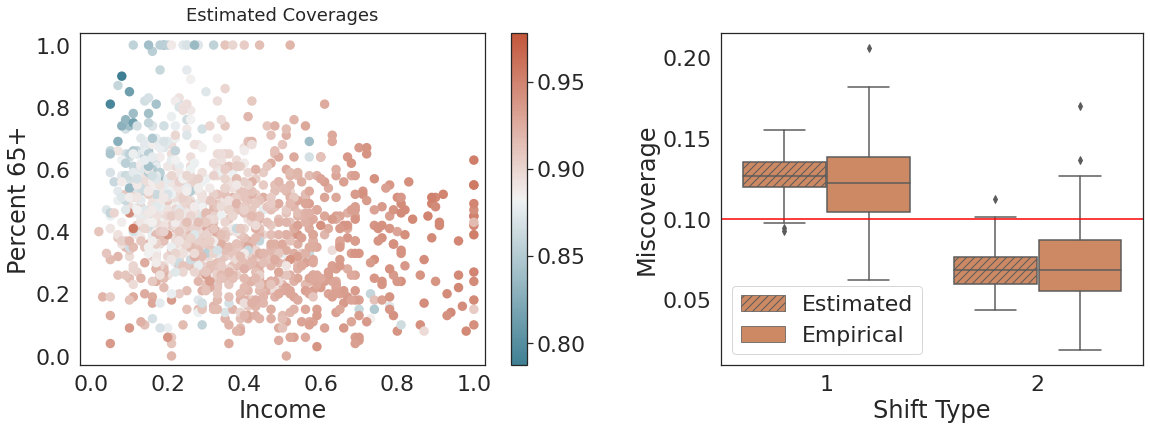

In [86]:
from matplotlib import gridspec

plt.rcParams["font.weight"] = "normal"
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()
fig.set_size_inches(16.5, 6.5)
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1]) 

ax1 = plt.subplot(gs[0])
f = sns.scatterplot(scatterplotDF,x='Income',y='Percent 65+',hue='Estimated Coverage',s=pointSize,
                    ax = ax1, edgecolor='none', palette = sns.diverging_palette(220, 20, as_cmap=True))
plt.setp(ax1.get_legend().get_texts(), fontsize=14)# for legend text
plt.setp(ax1.get_legend().get_title(), fontsize=14)# for legend title
plt.rcParams["legend.markerscale"] = 1.6

norm = plt.Normalize(scatterplotDF['Estimated Coverage'].min(), scatterplotDF['Estimated Coverage'].max())
sm = plt.cm.ScalarMappable(cmap=sns.diverging_palette(220, 20, as_cmap=True), norm=norm)
ax1.get_legend().remove()
ax1.figure.colorbar(sm)
ax1.set_title("Estimated Coverages", fontsize=18, pad=12)


ax3 = plt.subplot(gs[1])
hueOrder = ['Estimated', 'Empirical']
f3 = sns.boxplot(shiftDF,x='Shift Type',y='Miscoverage',hue='type', ax = ax3,
                 hue_order = hueOrder, palette = [sns.color_palette()[1],sns.color_palette()[1]])
for i,thisbar in enumerate(f3.patches):
    # Set a different hatch for each bar
    if i ==1 or i == 4:
        thisbar.set_hatch('///')
for lp, hatch in zip(f3.legend().get_patches(), ['///','']):
    lp.set_hatch(hatch)

f3.axhline(alpha, color='red')
f.set(xlim=(-0.03,1.03),ylim=(-0.03,1.04))

plt.tight_layout()

